In [1]:
import pyspark.sql.functions as fn

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load from Parquet

In [4]:
df = spark.read.parquet('dataset/THB_cards.parquet')

In [5]:
df.createOrReplaceTempView("cards")

In [6]:
df.columns

['number',
 'rarity',
 'name',
 'convertedManaCost',
 'numColors',
 'colorIdentity',
 'encodedColorIdentity',
 'types',
 'encodedTypes',
 'subTypes',
 'encodedSubTypes',
 'superTypes',
 'encodedSuperTypes',
 'originalText',
 'filteredText',
 'power',
 'toughness']

## Groups 

### By color 

In [7]:
df.groupby('colorIdentity').count().show()

+-------------+-----+
|colorIdentity|count|
+-------------+-----+
|          G,W|    4|
|            B|   45|
|          R,W|    2|
|          G,R|    4|
|            U|   45|
|          B,W|    3|
|          B,R|    4|
|          G,U|    3|
|            W|   48|
|            R|   44|
|          B,U|    6|
|            G|   44|
|          U,W|    3|
|             |   14|
|          B,G|    2|
|          R,U|    2|
+-------------+-----+



### By type 

In [8]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [9]:
indexer = StringIndexer.load("models/pyspark/stringindexer_str_types")
model = StringIndexerModel.load("models/pyspark/stringindexer_model_str_types")

In [10]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Enchantment,Creature',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [11]:
df.agg(fn.min(df.encodedTypes),fn.max(df.encodedTypes)).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                8|
+-----------------+-----------------+



In [12]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('B,G', 2), 1),
 (('B,R', 2), 1),
 (('G,W', 2), 1),
 (('R', 4), 1),
 (('G', 2), 1),
 (('G', 3), 1),
 (('R', 4), 1),
 (('G', 4), 1),
 (('U', 3), 1),
 (('B', 4), 1)]

In [13]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey().collect()

In [14]:
map2

[(('', 0), 10),
 (('', 1), 1),
 (('', 6), 3),
 (('B', 2), 14),
 (('B', 3), 10),
 (('B', 4), 11),
 (('B', 5), 6),
 (('B', 6), 1),
 (('B', 8), 3),
 (('B,G', 2), 2),
 (('B,R', 2), 2),
 (('B,R', 6), 1),
 (('B,R', 8), 1),
 (('B,U', 2), 3),
 (('B,U', 6), 1),
 (('B,U', 7), 2),
 (('B,W', 2), 1),
 (('B,W', 4), 1),
 (('B,W', 8), 1),
 (('G', 2), 17),
 (('G', 3), 8),
 (('G', 4), 10),
 (('G', 5), 5),
 (('G', 6), 1),
 (('G', 8), 3),
 (('G,R', 2), 2),
 (('G,R', 4), 1),
 (('G,R', 6), 1),
 (('G,U', 2), 2),
 (('G,U', 3), 1),
 (('G,W', 2), 2),
 (('G,W', 6), 1),
 (('G,W', 7), 1),
 (('R', 2), 17),
 (('R', 3), 9),
 (('R', 4), 6),
 (('R', 5), 4),
 (('R', 6), 1),
 (('R', 8), 7),
 (('R,U', 2), 1),
 (('R,U', 4), 1),
 (('R,W', 2), 1),
 (('R,W', 4), 1),
 (('U', 2), 16),
 (('U', 3), 7),
 (('U', 4), 10),
 (('U', 5), 8),
 (('U', 6), 1),
 (('U', 8), 3),
 (('U,W', 2), 1),
 (('U,W', 3), 1),
 (('U,W', 6), 1),
 (('W', 2), 19),
 (('W', 3), 9),
 (('W', 4), 9),
 (('W', 5), 5),
 (('W', 6), 1),
 (('W', 7), 2),
 (('W', 8), 3)]

In [15]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(9)

In [16]:
hist

([0.0,
  0.8888888888888888,
  1.7777777777777777,
  2.6666666666666665,
  3.5555555555555554,
  4.444444444444445,
  5.333333333333333,
  6.222222222222221,
  7.111111111111111,
  8],
 [10, 1, 100, 45, 50, 28, 13, 5, 21])

In [17]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [18]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

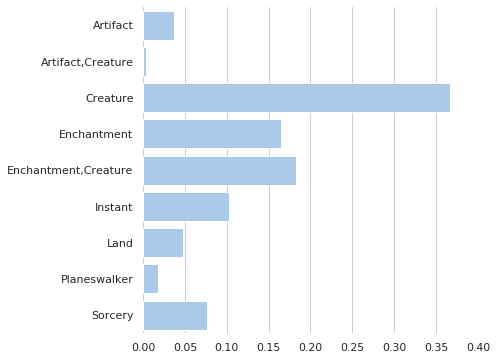

In [19]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
# ax.set(xlim=(0, 0.5), xlabel="%", ylabel="Creature type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

## SQL / FN

In [20]:
df.agg(*[fn.max(c).alias('max ' + c) for c in ['power', 'toughness']]).show()

+---------+-------------+
|max power|max toughness|
+---------+-------------+
|       10|            7|
+---------+-------------+



In [21]:
spark.sql("SELECT * FROM cards WHERE power == 10").show()

+------+------+------------+-----------------+---------+-------------+--------------------+--------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|number|rarity|        name|convertedManaCost|numColors|colorIdentity|encodedColorIdentity|   types|encodedTypes|subTypes|encodedSubTypes|superTypes|encodedSuperTypes|        originalText|        filteredText|power|toughness|
+------+------+------------+-----------------+---------+-------------+--------------------+--------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|   181|  rare|Nessian Boar|                5|        1|            G|                   6|Creature|           2|    Boar|              6|          |                0|All creatures abl...|All creatures abl...|   10|        6|
+------+------+------------+-----------------+---------+-------------+--------------------+-----

In [22]:
spark.sql("""
    SELECT * FROM cards
    ORDER BY power DESC, toughness DESC
    LIMIT 5
""").show()

+------+------+--------------------+-----------------+---------+-------------+--------------------+--------------------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|number|rarity|                name|convertedManaCost|numColors|colorIdentity|encodedColorIdentity|               types|encodedTypes|subTypes|encodedSubTypes|superTypes|encodedSuperTypes|        originalText|        filteredText|power|toughness|
+------+------+--------------------+-----------------+---------+-------------+--------------------+--------------------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|   181|  rare|        Nessian Boar|                5|        1|            G|                   6|            Creature|           2|    Boar|              6|          |                0|All creatures abl...|All creatures abl...|   10|        6|
|   297|  rare| 